# Higgs Challenge Example
In this part we will look at the **[Higgs Boson ML Challenge](https://www.kaggle.com/c/Higgs-boson)** on Kaggle and attempt a solution using Boosted Decision Trees (BDTs), a popular method in experimental particle physics. 

* BDTs are based on an ensemble of _weak classifiers_ (decision trees).
* Boosting increases the weight of misclassified events. 
* The data is available from **[CERN Open Data](http://opendata.cern.ch/record/328)**.
  * more information about the data is available from the links, and in particular in the accompanying **[documentation](http://opendata.cern.ch/record/329/files/atlas-higgs-challenge-2014.pdf)**.
  * much of the description below is taken from this documentation
* The general idea is that we want to extract $H\to\tau\tau$ signal from background. 
  * first channel where coupling of Higgs boson to fermions can be proven (before only coupling to bosons, $\gamma$, $W$, $Z$)
* In particular, the selection requires one of the taus to decay into an electron or muon and two neutrinos, and the other into hadrons and a neutrino. 
* The challenge is based on Monte Carlo collision events processed through the **[ATLAS detector](http://atlas.cern/)** simulation and reconstruction.

## LHC and ATLAS
* LHC collides bunches of protons every 50 nanoseconds inside ATLAS
* In the hard-scattering process, two colliding protons interact and part of the kinetic energy of the protons is converted into new particles.
* Most resulting particles are very unstable and decay quickly into a cascade of lighter particles.
* ATLAS detector measures the properties of the decay products: type, energy and momentum (3-D direction)
* The decay products are identified and reconstructed from the low-level analogue and digital signals they trigger in the detector hardware.
* Part of the energy will be converted into and carried away by neutrinos (e.g. from the decay of tau leptons) that cannot be measured, leading to an incomplete event reconstruction.

Some event displays that visualize collision events found in real data that show a signature matching a $H\to\tau\tau$ decay can be found on the [public ATLAS page][1]. [This event][2], for example, shows $H\to\tau\tau$ with one tau lepton further decaying leptonically and the other hadronically.

[1]: https://twiki.cern.ch/twiki/bin/view/AtlasPublic/EventDisplaysFromHiggsSearches#H_AN1
[2]: https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/CONFNOTES/ATLAS-CONF-2012-160/figaux_07.png

## Basic setup

In [1]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')
len(df)

818238

## The Dataset
The data contains > 800 k simulated collision events, that were used in the reference [ATLAS analysis][1]:
* 250 k for training
* 100 k for testing (public leaderboard)
* 450 k for testing (private leaderboard)
* a small withheld dataset

Here, we use the full dataset:

[1]: http://cds.cern.ch/record/1632191

In [3]:
df.groupby("KaggleSet").count()["EventId"]

KaggleSet
b    100000
t    250000
u     18238
v    450000
Name: EventId, dtype: int64

The dataset mixes background (b) and signal (s) events:

In [4]:
df.groupby("Label").count()["EventId"]

Label
b    538678
s    279560
Name: EventId, dtype: int64

If the actual $s:b$ ratio were so large ($\sim1/3$), we would have found the Higgs much earlier. 
To obtain the actual number of signal and background events we expect in the 2012 ATLAS dataset, we need to take into account the provided weights:

In [5]:
df.groupby("Label").sum()["Weight"]

Label
b    410999.847322
s       691.988608
Name: Weight, dtype: float64

That is, without any additional selection we expect a signal-background ratio of only 1.7 permille.

Each simulated event has a weight
* proportional to the conditional density divided by the instrumental density used by the simulator (an importance-sampling flavor),
* and normalized for integrated luminosity (the size of the dataset; factors in cross section, beam intensity and run time of the collider)

The weights are an artifact of the way the simulation works and not part of the input to the classifier.

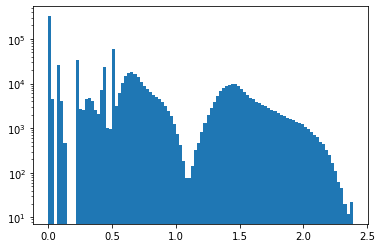

In [6]:
# different weights correspond roughly to different background processes (due to the different cross sections)
ax = plt.hist(df["Weight"], bins = 100)
plt.yscale('log')

Only three different background processes were retained in this dataset ($Z\to\tau\tau$, top-quark-pair production, $W\to\ell\nu$).

## Exploring the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818238 entries, 0 to 818237
Data columns (total 35 columns):
EventId                        818238 non-null int64
DER_mass_MMC                   818238 non-null float64
DER_mass_transverse_met_lep    818238 non-null float64
DER_mass_vis                   818238 non-null float64
DER_pt_h                       818238 non-null float64
DER_deltaeta_jet_jet           818238 non-null float64
DER_mass_jet_jet               818238 non-null float64
DER_prodeta_jet_jet            818238 non-null float64
DER_deltar_tau_lep             818238 non-null float64
DER_pt_tot                     818238 non-null float64
DER_sum_pt                     818238 non-null float64
DER_pt_ratio_lep_tau           818238 non-null float64
DER_met_phi_centrality         818238 non-null float64
DER_lep_eta_centrality         818238 non-null float64
PRI_tau_pt                     818238 non-null float64
PRI_tau_eta                    818238 non-null float64
PRI_tau_phi

In [8]:
df.head().T

,0,1,2,3,4
EventId,100000,100001,100002,100003,100004
DER_mass_MMC,138.47,160.937,-999,143.905,175.864
DER_mass_transverse_met_lep,51.655,68.768,162.172,81.417,16.915
DER_mass_vis,97.827,103.235,125.953,80.943,134.805
DER_pt_h,27.98,48.146,35.635,0.414,16.405
DER_deltaeta_jet_jet,0.91,-999,-999,-999,-999
DER_mass_jet_jet,124.711,-999,-999,-999,-999
DER_prodeta_jet_jet,2.666,-999,-999,-999,-999
DER_deltar_tau_lep,3.064,3.473,3.148,3.31,3.891
DER_pt_tot,41.928,2.078,9.336,0.414,16.405


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
EventId,818238.0,509118.500000,236205.109119,100000.000000,304559.250000,509118.500000,713677.750000,918237.000000
DER_mass_MMC,818238.0,-48.819019,406.118397,-999.000000,78.166000,105.061000,130.730000,1949.261000
DER_mass_transverse_met_lep,818238.0,49.252714,35.378609,0.000000,19.304000,46.484000,73.620000,968.669000
DER_mass_vis,818238.0,81.140561,40.582708,6.329000,59.414000,73.744000,92.188000,1349.351000
DER_pt_h,818238.0,57.849524,63.411938,0.000000,14.164250,38.470000,79.226750,2834.999000
DER_deltaeta_jet_jet,818238.0,-707.740880,454.793899,-999.000000,-999.000000,-999.000000,0.499000,8.724000
DER_mass_jet_jet,818238.0,-600.191191,658.724040,-999.000000,-999.000000,-999.000000,84.031750,4974.979000
DER_prodeta_jet_jet,818238.0,-708.681306,453.328599,-999.000000,-999.000000,-999.000000,-4.548000,17.650000
DER_deltar_tau_lep,818238.0,2.373871,0.780875,0.208000,1.814000,2.492000,2.962000,5.751000
DER_pt_tot,818238.0,18.969617,21.918491,0.000000,2.839000,12.383000,27.634000,2834.999000


### Brief overview on variables, there is more information in the documentation. 
* 30 features
  * The variables that start with **DER** are derived quantities, determined by the physicists performing the analysis as variables that discriminate signal from background. 
  * On the other hand, those that start with **PRI** are considered to be primary variables, from which the derived variables are calculated. 
    * They themselves generally do not provide much discrimination.
    * One of the ideas suggested by deep networks is that they can determine the necessary features from the primary variables, potentially even finding variables that the physicists did not consider. 
* *EventId* identifies the event but is not a "feature." 
* The *Weight* is the event weight.
  * used to obtain the proper normalization of the different signal and background samples
  * sum of weights of all signal events should produce the signal yield expected to be observed in 2012 LHC data taking
  * sum of weights of all background events should produce the background yield
* *Label* indicates if it is a signal or background event. 
* Ignore the *Kaggle* variables --- they are only used if you want to reproduce exactly what was used in the Challenge. 

### Investigate/visualize some parameters

In [10]:
import seaborn as sns

In [11]:
df.keys()

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label', 'KaggleSet', 'KaggleWeight'],
      dtype='object')

In [12]:
# take sub-set of vars for plotting
varplot = ['DER_mass_MMC', 'DER_mass_jet_jet',
       'DER_deltar_tau_lep', 'DER_pt_tot','PRI_jet_subleading_pt']


In [13]:
# Preprocessing: map labels to integers
df['Label'] = df['Label'].map({'b':0, 's':1})

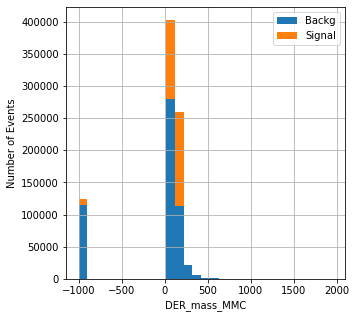

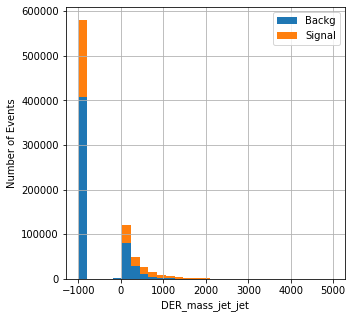

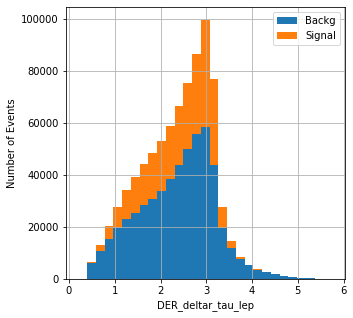

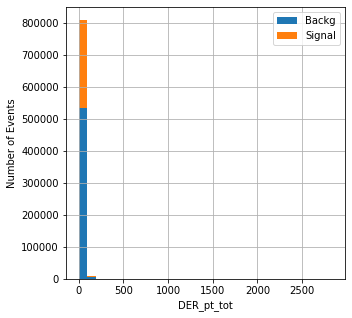

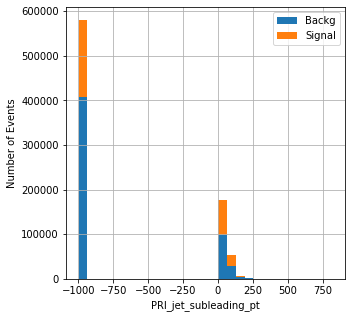

In [14]:
# direct histograms
for key in varplot:
    # plotting settings
    fig = plt.figure(figsize=(5, 5))
    bins = np.linspace(min(df[key]), max(df[key]), 30)
    # plot signal & backg
    p = plt.hist([df[df['Label']==0][key],df[df['Label']==1][key]], bins=bins, stacked=True,label=['Backg','Signal'])
    
    # decorate
    plt.xlabel(key)
    plt.ylabel('Number of Events')
    plt.legend()
    plt.grid()
    plt.plot()

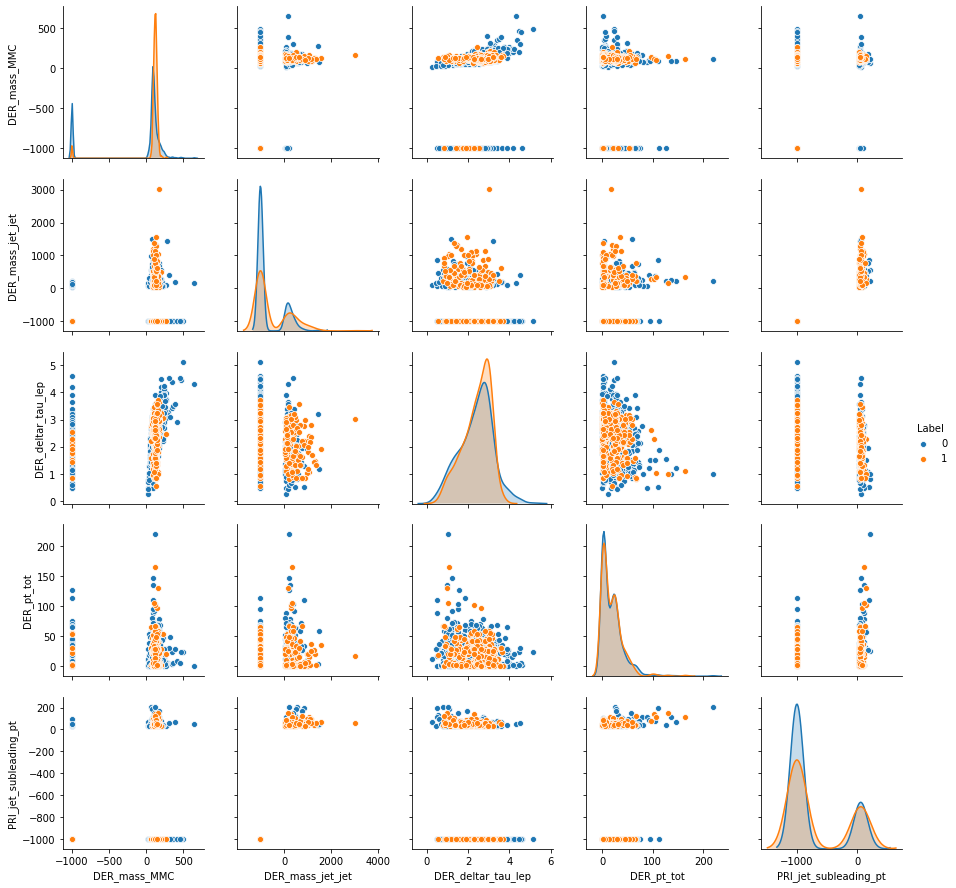

In [15]:
# plot only first 10k entries
_ = sns.pairplot(df.iloc[:1000], hue='Label', vars=varplot) 

(The diagonal plot use _kernel density estimation_ to smear out data points in phase space and add up the result to obtain a smooth function.)

### Further dataset preprocessing

In [ ]:
# let's create separate arrays for ML models
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt'] # features to train on
y = df['Label'] # labels
weight = df['Weight']

In [ ]:
X.describe().T

In [ ]:
X.columns

In [ ]:
# now split data and weights into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

## First ML trials w/ simple models
1st attempt with simple models: GaussianNB and Logistic Regression
* train
* test
* plot scores


### GaussianNB

In [ ]:
# GaussianNB (Gaussian Naive Bayes, assumes each class is drawn from an axis-aligned Gaussian distribution)
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(X_train, y_train)                # 3. fit model to data
gnb = model.predict(X_test)                # 4. predict on new data

In [ ]:
model.score(X_test, y_test)

In [ ]:
# define function to plot probability for sig/bg
def plot_proba( df, model, x ):
    df['Prob']=model.predict_proba(x)[:, 1]
    kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
    df[df.Label==0].Prob.hist(label='Background',**kwargs)
    df[df.Label==1].Prob.hist(label='Signal',**kwargs)
    _=plt.legend()

In [ ]:
plot_proba( df, model, X)

###  Logistic Regression
As next attempt, let's look at [logistic regression][1]. This is a very simple, linear model. In the exercises you can look at optimizing it a bit more.
* logistic function: $f(x) = \frac{1}{1+\exp(-x)}$, $f(x): [-\infty,\infty] \to [0,1]$
* model: $y_i = f(x_i \cdot \beta) + \epsilon_i$

[1]: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(solver = "lbfgs")

(lbfgs = limited-memory BFGS, BFGS = Broyden–Fletcher–Goldfarb–Shanno algorithm, an iterative method for solving unconstrained nonlinear optimization problems)

In [ ]:
# fit takes a few seconds...
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_test,y_test)

In [ ]:
# check prob dist
plot_proba(df, lr, X)

####  Logistic Regression - v2
Now repeat but with fewer features

In [ ]:
X_train.loc[:,:'DER_pt_tot'].columns

In [ ]:
# Let's try using fewer features
lr2 = LogisticRegression(solver = "lbfgs")

In [ ]:
lr2.fit(X_train.loc[:,:'DER_pt_tot'], y_train)

In [ ]:
lr2.score(X_test.loc[:,:'DER_pt_tot'], y_test)

In [ ]:
# check prob dist
plot_proba( df, lr2, X.loc[:,:'DER_pt_tot'])

## More sophisticated model: GradientBoostingClassifier
The [GradientBoostingClassifier][1] provides _gradient-boosted regression trees_. 
* ensemble method that combines multiple decision trees
* "forward stage-wise fashion: each tree tries to correct the mistakes of the previous one (steered by the `learning_rate`)
* trees are simple (shallow), idea is to combine many "weak learners" 
  * each tree can only provide good predictions on part of the data, but combined they can yield a powerful model
  
[1]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [ ]:
# now let's define the model
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=10,
                                    min_samples_leaf=200,
                                    max_features=10, verbose=1)


In [ ]:
# fit takes several minutes... can look into AMS while it runs
gbc.fit(X_train, y_train) # (and n_jobs is not supported)

In [ ]:
gbc.score(X_test, y_test)

In [ ]:
# check prob dist
plot_proba(df, gbc, X)

#### GBC also useful to judge/quantify importance of features

In [ ]:
gbc.feature_importances_

In [ ]:
for importance, key in sorted(zip(gbc.feature_importances_, X.keys())):
    print ("%30s %6.3f" % (key, importance))


## Figure-of-Merit: AMS
Let's get back to the original problem using the GradientBoostingClassifier. The Kaggle competition used the approximate median significance ([AMS][1]), as defined below, to determine how good a solution was. 
The goal is to maximize signal and minimize background, and the AMS is an approximate formula to quantify the signal significance. The maximal AMS gives best signal significance. 

Note that if you do not use the full data set (i.e. you split into training and testing) you have to reweigh the inputs so that the subsample yield matches to the total yield, which we will do below.

[1]: AMS.ipynb

In [ ]:
# compute approximate median significance (AMS)
def ams(s,b):
    from math import sqrt,log
    if b==0: # not really needed
        return 0
    # The number 10, added to the background yield, is a regularization term to decrease the variance of the AMS.
    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

In [ ]:
# Let's try a different probability cut, not the one given by default to predict().
# We choose the top 20% (i.e. 20 % of unweighted events above pcut will be classified as signal), but can optimize
y_train_prob = gbc.predict_proba(X_train)[:, 1]
y_test_prob  = gbc.predict_proba(X_test)[:, 1]
pcut = np.percentile(y_train_prob, 80) # NOTE: using y_train_prob here
print("pcut of %f selects %.2f %%" % (pcut, 100*len(y_train_prob[y_train_prob > pcut]) / len(y_train_prob)))

**Now include the weights** to get proper normalization  

In [ ]:
wgtsig  = df[df.Label==1].Weight
wgtback = df[df.Label==0].Weight

# the density argument makes this a normalized plot (otherwise wouldn't see the signal on linear scale)
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40, density = True)

df[df.Label==0].Prob.hist(label='Background', weights=wgtback, **kwargs)
df[df.Label==1].Prob.hist(label='Signal', weights=wgtsig, **kwargs)
_ = plt.legend()
#plt.yscale('log') -- to try without density

In [ ]:
# let's calculate the total weights (yields)
sigall  = weight.dot(y == 1)
backall = weight.dot(y == 0)

# training-sample weights
sigtrain  = weight_train.dot(y_train)
backtrain = weight_train.dot(y_train == 0)

# test-sample weights
sigtest  = weight_test.dot(y_test)
backtest = weight_test.dot(y_test == 0)

# aside:  these can also be done by looping instead of using a dot product
#  (Usually vectorized operations are faster for interpreted code)

In [ ]:
print ("All  :", sigall, backall)
print ("Train:", sigtrain, backtrain)
print ("Test :", sigtest, backtest)

In [ ]:
# Now let's look at event yields that pass our selection
sigtrain_sel  = weight_train.dot(np.multiply(y_train     , y_train_prob > pcut))
backtrain_sel = weight_train.dot(np.multiply(y_train == 0, y_train_prob > pcut))

sigtest_sel  = weight_test.dot(np.multiply(y_test     , y_test_prob > pcut))
backtest_sel = weight_test.dot(np.multiply(y_test == 0, y_test_prob > pcut))


In [ ]:
# signal and background efficiency
print ("Train: eps_s = %f, eps_b = %f (eps_total: %f)" % (sigtrain_sel / sigtrain, backtrain_sel / backtrain,
                                                     (sigtrain_sel+backtrain_sel) / (sigtrain+backtrain)))
print ("Test : eps_s = %f, eps_b = %f" % (sigtest_sel / sigtest, backtest_sel / backtest))

In [ ]:
# Now we need to scale-up the selected yields to the (luminosity of the) original full sample
sigtrain_sel_corr  = sigtrain_sel*sigall/sigtrain
backtrain_sel_corr = backtrain_sel*backall/backtrain

sigtest_sel_corr  = sigtest_sel*sigall/sigtest
backtest_sel_corr = backtest_sel*backall/backtest

print("Scaled selected yields in training sample, signal =", sigtrain_sel_corr, ", background =",backtrain_sel_corr)
print("Scaled selected yields in test sample, signal =", sigtest_sel_corr, ", background =",backtest_sel_corr)


## ROC curve

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:, 1], sample_weight = weight_test)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
mark_threshold = pcut # mark selected threshold
idx = np.argmin(np.abs(thresholds - mark_threshold))
plt.plot(fpr[idx], tpr[idx], 'o', markersize=10, label="threshold %f" % mark_threshold, fillstyle="none", mew=2)
_ = plt.legend(loc=4)

* TPR = true positive rate = TP / (TP+FN) = TP / P (= recall)
* FPR = false positive rate = FP / (FP+TN) = FP / N

_Note_: As we have a lot more background than signal events, we typically want to choose a point with a very low false-positive rate. While we can use the ROC curve to compare different classifiers, a better performance measure is the AMS.

In [ ]:
print("AMS of training sample", ams(sigtrain_sel_corr, backtrain_sel_corr))
print("AMS of test sample", ams(sigtest_sel_corr, backtest_sel_corr))

## Create plot of AMS vs Pcut

In [ ]:
# helper function to calculate AMS for different pcut
def calc_ams(pcut):
    sigtest_sel  = weight_test.dot(np.multiply(y_test     , y_test_prob > pcut))
    backtest_sel = weight_test.dot(np.multiply(y_test == 0, y_test_prob > pcut))
    sigtest_sel_corr  = sigtest_sel*sigall/sigtest
    backtest_sel_corr = backtest_sel*backall/backtest
    return(ams(sigtest_sel_corr, backtest_sel_corr))

In [ ]:
# AMS plot
xv=np.linspace(0.,0.99,50)
yv=np.vectorize(calc_ams)(xv)
plt.plot(xv,yv)
plt.xlabel('Pcut') # x-axis
plt.ylabel('AMS')# y-axis
plt.grid(True)
# mark chosen pcut
idx = np.argmin(np.abs(xv - pcut))
plt.plot(xv[idx], yv[idx], 'o', markersize=10, label="pcut", fillstyle="none", mew=2)
_ = plt.legend()

How did we do? Not too bad. Here are the scores of real submissions.
![Comparison with submissions](figures/tr150908_davidRousseau_TMVAFuture_HiggsML.001.png)

This is of course a bit of a simplification from a real physics analysis, where systematics often seem to take the most time. They are ignored here.
![Comparison with real analysis](figures/tr140415_davidRousseau_Rome_Higgs_MVA_HiggsML.001.png)

* _systematics_: systematic uncertainties on the event yields and BDT distributions, of experimental and theoretical origin (cf. section 11 in reference analysis)
* _categories_: the reference analysis discriminates two production mechanisms of the Higgs boson, VBF (events with two characteristic jets from vector-boson fusion) and boosted (all other events, dominated by gluon fusion)
* _embedded_: dominant Z→τ⁺τ⁻ background is taken from "τ-embedded Z→μ⁺μ⁻ data"
* _anti tau_: revert some tau-identification criterion to create an "anti(-ID) tau" sample (used in "fake-factor method" to estimate background with objects misidentified as tau leptons)
* _control regions_: phase-space regions enriched in (one type of) background process that allow to normalize a predicted background contribution to that observed in data
* _tt_: background process, events with pair production of top quarks ($t\bar t$)
* _NP_: nuisance parameters (parameters of fit model that are not of physical interest but give it more flexibility to describe the data)
* _TMVA_: [Toolkit for Multivariate Data Analysis with ROOT][1], a ROOT-integrated project providing an ML environment for multivariate classification and regression techniques

[1]: https://root.cern.ch/tmva


# Your tasks
What to work on for the rest of the day:
1. Look at the definition of the variables in the manual to get a rough feeling for what physics they encode.
1. Attempt to calculate the AMS for the logistic regression cases.
1. Do we overfit? Add plots to see.
1. Which variables are important?
1. Should we **[preprocess](http://scikit-learn.org/stable/modules/preprocessing.html)** the input data to be the same scale? Note that we have some -999 values that indicate the variable could not be calculated.
1. We do not use the event weights in the training. Can they help? Note, that you don't want to just apply the weights as is since they will make background dominate over signal.
1. The best scores in the Challenge all used cross-validation; if you have time, try to implement it.

*Later we will continue on this example with neural networks.*